In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("assets/data.csv")
df.head(30)

,sf,mesos,success,maintain,degrade,break
0,0,10000,1.00,0.00,0.00,0.00
1,1,15000,0.95,0.05,0.00,0.00
2,2,30000,0.90,0.10,0.00,0.00
3,3,55000,0.85,0.15,0.00,0.00
4,4,100000,0.80,0.20,0.00,0.00
5,5,180000,0.75,0.25,0.00,0.00
6,6,270000,0.70,0.30,0.00,0.00
7,7,360000,0.65,0.35,0.00,0.00
8,8,450000,0.60,0.40,0.00,0.00
9,9,540000,0.55,0.45,0.00,0.00


In [2]:
# 350 crystal per scroll
decline_scroll_cost = 350 / 3 
shield_scroll_cost = 350 / 3 

# 160m mesos for 7% luky scroll
lucky_scroll_cost = 160_000_000 

In [3]:
class Gear:
    
    def __init__(self, current_sf=1, target_sf=30):
        self.target_sf = target_sf
        self.current_sf = current_sf
        self.success_count = 0
        self.maintain_count = 0
        self.degrade_count = 0
        self.broken_count = 0
        self.attempt_count = 0
        
        self.mesos_cost = 0
        self.crystal_cost = 0
        
        self.lucky_used = 0
        self.ward_used = 0 # destroy prevention
        self.shield_used = 0 # decline prevention
    
    def rng(self):
        return random.random()
    
    @property
    def success(self):
        # bonus 5%, assume hitting orange bar 95% of the time
        return df.iloc[self.current_sf]['success'] + 0.05 * (self.rng() <= 0.95)
    
    @property
    def maintain(self):
        return df.iloc[self.current_sf]['maintain']
    
    @property
    def degrade(self):
        return df.iloc[self.current_sf]['degrade']
    
    @property
    def destroy(self):
        return df.iloc[self.current_sf]['break']
    
    @property
    def mesos(self):
        return df.iloc[self.current_sf]['mesos']
        
    def enhance(self, use_decline_scroll=False, use_shield_scroll=False, use_lucky_scroll=False):
        self.attempt_count += 1
        self.mesos_cost += self.mesos
        
        success_thresh = self.success
        if use_lucky_scroll:
            success_thresh += 0.07
            self.lucky_used += 1
        
        degrade_thresh = success_thresh + self.degrade
        if use_decline_scroll:
            degrade_thresh = success_thresh
            self.crystal_cost += decline_scroll_cost
            self.shield_used += 1
        
        break_thresh = degrade_thresh + self.destroy
        if use_shield_scroll:
            break_thresh = degrade_thresh
            self.crystal_cost += shield_scroll_cost
            self.ward_used += 1
        
        rn = self.rng()
        if rn <= success_thresh:
            # enhancement success
            self.success_count += 1
            self.current_sf += 1
        elif rn <= degrade_thresh:
            # decrease star force
            self.current_sf -= 1
            self.degrade_count += 1
        elif rn <= break_thresh:
            # equipment breaks, maintain current level (assume transfer)
            # self.current_sf = 0
            self.broken_count += 1
        else:
            # maintain current level
            self.maintain_count += 1
        
    def should_continue(self):
        return self.current_sf < self.target_sf
        
    def __str__(self):
        return f"current sf: {self.current_sf}, mesos cost: {self.mesos_cost}, crystal cost: {self.crystal_cost}, attempt: {self.attempt_count}, broke: {self.broken_count}"

In [4]:
class Simulator:
    def __init__(self, current_sf, target_sf):
        self.current_sf = current_sf
        self.target_sf = target_sf
        
    def simulate(self, trial=100, verbose=False, 
                 use_decline_scroll=False, use_shield_scroll=False, use_lucky_scroll=False):
        mesos_arr = np.zeros(trial)
        attempt_arr = np.zeros(trial)
        success_arr = np.zeros(trial)
        maintain_arr = np.zeros(trial)
        degrade_arr = np.zeros(trial)
        broken_arr = np.zeros(trial)
        crystal_arr = np.zeros(trial)
        lucky_arr = np.zeros(trial)
        shield_arr = np.zeros(trial) # decline prevention
        ward_arr = np.zeros(trial) # destroy prevention
        
        for i in range(trial):
            gear = Gear(current_sf=self.current_sf, target_sf=self.target_sf)
            while gear.should_continue():
                gear.enhance(use_decline_scroll, use_shield_scroll, use_lucky_scroll)
            
            mesos_arr[i] = gear.mesos_cost
            attempt_arr[i] = gear.attempt_count
            success_arr[i] = gear.success_count
            maintain_arr[i] = gear.maintain_count
            degrade_arr[i] = gear.degrade_count
            broken_arr[i] = gear.broken_count
            crystal_arr[i] = gear.crystal_cost
            lucky_arr[i] = gear.lucky_used
            shield_arr[i] = gear.shield_used
            ward_arr[i] = gear.ward_used
        
        return {
            "mesos": np.mean(mesos_arr),
            "attempt": np.mean(attempt_arr),
            "broken": np.mean(broken_arr),
            "crystal": np.mean(crystal_arr),
            "lucky": np.mean(lucky_arr),
            "shield": np.mean(shield_arr),
            "ward": np.mean(ward_arr),
        }

#### Check

In [5]:
success = 0
maintain = 0
degrade = 0
broken = 0
trial = 1000
for i in range(trial):
    gear = Gear(current_sf=10, target_sf=11)
    gear.enhance(use_lucky_scroll=False)
    
    success += gear.success_count
    maintain += gear.maintain_count
    degrade += gear.degrade_count
    broken += gear.broken_count
    
print("success: %.2f"%(success/trial))
print("maintain: %.2f"%(maintain/trial))
print("degrade: %.2f"%(degrade/trial))
print("broken: %.2f"%(broken/trial))

print("true probability (exclude bonus 5%):")
df.iloc[10]

success: 0.56
maintain: 0.31
degrade: 0.09
broken: 0.04
true probability (exclude bonus 5%):


sf              10.00
mesos       560000.00
success          0.50
maintain         0.35
degrade          0.10
break            0.05
Name: 10, dtype: float64

In [6]:
simulator = Simulator(current_sf=10, target_sf=11)
simulator.simulate(trial=100, verbose=True)

{'mesos': 1275600.0,
 'attempt': 2.29,
 'broken': 0.14,
 'crystal': 0.0,
 'lucky': 0.0,
 'shield': 0.0,
 'ward': 0.0}

#### Build the Matrix

In [7]:
row = 20 # start level
col = 21 # target level

mesos_mat = np.zeros((row, col))
attempt_mat = np.zeros((row, col))
broken_mat = np.zeros((row, col))
crytal_mat = np.zeros((row, col))
lucky_mat = np.zeros((row, col))
shield_mat = np.zeros((row, col))
ward_mat = np.zeros((row, col))

for r in range(row):
    for c in range(col):
        print(f"simulating from sf {r} to sf {c}", end="\r")
        simulator = Simulator(current_sf=r, target_sf=c)
        result = simulator.simulate(
            trial=1000, use_decline_scroll=False, use_shield_scroll=False, use_lucky_scroll=False)
        
        mesos_mat[r, c] = result['mesos']
        attempt_mat[r, c] = result['attempt']
        broken_mat[r, c] = result['broken']
        crytal_mat[r, c] = result['crystal']
        lucky_mat[r, c] = result['lucky']
        shield_mat[r, c] = result['shield']
        ward_mat[r, c] = result['ward']

In [8]:
pd.DataFrame(attempt_mat).to_clipboard()
pd.DataFrame(attempt_mat).to_csv('output/attempt_mat.csv')

In [9]:
pd.DataFrame(mesos_mat).to_clipboard()
pd.DataFrame(mesos_mat).to_csv('output/mesos_mat.csv')

In [10]:
pd.DataFrame(broken_mat).to_clipboard()
pd.DataFrame(broken_mat).to_csv('output/broken_mat.csv')

In [11]:
pd.DataFrame(crytal_mat).to_clipboard()
pd.DataFrame(crytal_mat).to_csv('output/crytal_mat.csv')

#### Trial Run SF 1-15

In [12]:
gear = Gear(current_sf=0)
while gear.current_sf != 15:
    gear.enhance()
    print(gear)

current sf: 1, mesos cost: 10000.0, crystal cost: 0, attempt: 1, broke: 0
current sf: 2, mesos cost: 25000.0, crystal cost: 0, attempt: 2, broke: 0
current sf: 3, mesos cost: 55000.0, crystal cost: 0, attempt: 3, broke: 0
current sf: 3, mesos cost: 110000.0, crystal cost: 0, attempt: 4, broke: 0
current sf: 4, mesos cost: 165000.0, crystal cost: 0, attempt: 5, broke: 0
current sf: 5, mesos cost: 265000.0, crystal cost: 0, attempt: 6, broke: 0
current sf: 6, mesos cost: 445000.0, crystal cost: 0, attempt: 7, broke: 0
current sf: 7, mesos cost: 715000.0, crystal cost: 0, attempt: 8, broke: 0
current sf: 8, mesos cost: 1075000.0, crystal cost: 0, attempt: 9, broke: 0
current sf: 9, mesos cost: 1525000.0, crystal cost: 0, attempt: 10, broke: 0
current sf: 10, mesos cost: 2065000.0, crystal cost: 0, attempt: 11, broke: 0
current sf: 10, mesos cost: 2625000.0, crystal cost: 0, attempt: 12, broke: 0
current sf: 10, mesos cost: 3185000.0, crystal cost: 0, attempt: 13, broke: 0
current sf: 10, 

#### Trial Run SF 15-20 (no scroll)

In [13]:
gear = Gear(current_sf=17)
while gear.current_sf != 20:
    gear.enhance()
    
print(gear)
print(f"mesos: {gear.mesos_cost}, crystal: {gear.crystal_cost}")

current sf: 20, mesos cost: 756960000.0, crystal cost: 0, attempt: 379, broke: 15
mesos: 756960000.0, crystal: 0


#### Trial Run SF 15-20 (use scroll)

In [14]:
gear = Gear(current_sf=1)
print("start:", gear)
while gear.current_sf != 18:
    gear.enhance(use_decline_scroll=True, use_lucky_scroll=False, use_shield_scroll=True)
    print(gear)
    
print("end:", gear)
print(f"mesos: {gear.mesos_cost}, crystal: {gear.crystal_cost}")

start: current sf: 1, mesos cost: 0, crystal cost: 0, attempt: 0, broke: 0
current sf: 2, mesos cost: 15000.0, crystal cost: 233.33333333333334, attempt: 1, broke: 0
current sf: 3, mesos cost: 45000.0, crystal cost: 466.6666666666667, attempt: 2, broke: 0
current sf: 4, mesos cost: 100000.0, crystal cost: 700.0, attempt: 3, broke: 0
current sf: 5, mesos cost: 200000.0, crystal cost: 933.3333333333333, attempt: 4, broke: 0
current sf: 6, mesos cost: 380000.0, crystal cost: 1166.6666666666667, attempt: 5, broke: 0
current sf: 6, mesos cost: 650000.0, crystal cost: 1400.0000000000002, attempt: 6, broke: 0
current sf: 7, mesos cost: 920000.0, crystal cost: 1633.3333333333337, attempt: 7, broke: 0
current sf: 8, mesos cost: 1280000.0, crystal cost: 1866.6666666666672, attempt: 8, broke: 0
current sf: 9, mesos cost: 1730000.0, crystal cost: 2100.0000000000005, attempt: 9, broke: 0
current sf: 10, mesos cost: 2270000.0, crystal cost: 2333.3333333333335, attempt: 10, broke: 0
current sf: 10, m

#### Trial Run SF 20-30 (full scroll)

In [15]:
gear = Gear(current_sf=20)
print("start:", gear)
while gear.current_sf != 30:
    gear.enhance(use_decline_scroll=True, use_lucky_scroll=True, use_shield_scroll=True)    
print("end:", gear)
print(f"mesos: {gear.mesos_cost}, crystal: {gear.crystal_cost}")

start: current sf: 20, mesos cost: 0, crystal cost: 0, attempt: 0, broke: 0
end: current sf: 30, mesos cost: 959800000.0, crystal cost: 18199.999999999985, attempt: 78, broke: 0
mesos: 959800000.0, crystal: 18199.999999999985


### Monte Carlo Simulation
* Each experiment levels SF 20 to 30 using three scrolls.
* Run the experiment 10000 times. 
* Record mesos and crystal expense for each experiment
* Plot distribution

In [16]:
import numpy as np

trial = 100
crystal_cost_array = np.zeros(trial)
mesos_cost_array = np.zeros(trial)
attempt_array = np.zeros(trial)
broken_array = np.zeros(trial)
for i in range(trial):
    gear = Gear(current_sf=20)
    while gear.current_sf != 30:
        gear.enhance(use_decline_scroll=True, use_lucky_scroll=True, use_shield_scroll=True)
    
    crystal_cost_array[i] = gear.crystal_cost
    mesos_cost_array[i] = gear.mesos_cost
    attempt_array[i] = gear.attempt_count
    broken_array[i] = gear.broken_count
    print(f"trial {i}/{trial}", end="\r")

Text(0.5, 0, 'broken')

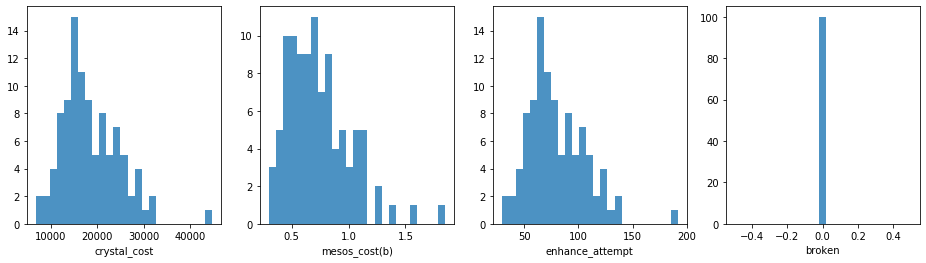

In [17]:
plt.figure(figsize=(16, 4))

ax1 = plt.subplot(1, 4, 1)
ax1.hist(crystal_cost_array, alpha=0.8, bins=25)
ax1.set_xlabel("crystal_cost")

ax2 = plt.subplot(1, 4, 2)
ax2.hist(mesos_cost_array/1e9, alpha=0.8, bins=25)
ax2.set_xlabel("mesos_cost(b)")

ax3 = plt.subplot(1, 4, 3)
ax3.hist(attempt_array, alpha=0.8, bins=25)
ax3.set_xlabel("enhance_attempt")

ax4 = plt.subplot(1, 4, 4)
ax4.hist(broken_array, alpha=0.8, bins=25)
ax4.set_xlabel("broken")

In [18]:
print("average cost: %.2f crystal"%np.mean(crystal_cost_array))
print("average cost: %.2f mesos"%np.mean(mesos_cost_array))
print("average broken: %.2f"%np.mean(broken_array))
print("average attempt: %.2f"%np.mean(attempt_array))

average cost: 18622.33 crystal
average cost: 736272000.00 mesos
average broken: 0.00
average attempt: 79.81
